In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import copy

In [518]:
class LSTM(nn.Module):
    def __init__(self, inSize, hiddenSize, outSize=None):
        super().__init__()
        self.hiddenSize = hiddenSize

        self.forget = nn.Linear(inSize + hiddenSize, hiddenSize)
        self.input = nn.Linear(inSize + hiddenSize, hiddenSize)
        self.candidate = nn.Linear(inSize + hiddenSize, hiddenSize)
        self.output = nn.Linear(inSize + hiddenSize, hiddenSize)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        if outSize == None:
            outSize = inSize
        
        self.prediction = nn.Linear(hiddenSize, outSize)

    def forward(self, x, states):
        inShortTerm, inLongTerm = states

        combined = torch.cat((x, inShortTerm), dim=-1)

        forget = self.sigmoid(self.forget(combined))
        inputt = self.sigmoid(self.input(combined))
        candidate = self.tanh(self.candidate(combined))
        output = self.sigmoid(self.output(combined))

        outLongTerm = forget * inLongTerm + inputt * candidate

        outShortTerm =  output * self.tanh(outLongTerm)

        return outShortTerm, outLongTerm
    

    def predict(self, outShortTerm):
        return self.prediction(outShortTerm)

    def initStates(self, batchSize):
        return (
            torch.zeros(batchSize, self.hiddenSize),
            torch.zeros(batchSize, self.hiddenSize),
        )
    


In [519]:
device = torch.device('cuda')
model = LSTM(1,16)
model.to(device)

LSTM(
  (forget): Linear(in_features=17, out_features=16, bias=True)
  (input): Linear(in_features=17, out_features=16, bias=True)
  (candidate): Linear(in_features=17, out_features=16, bias=True)
  (output): Linear(in_features=17, out_features=16, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (prediction): Linear(in_features=16, out_features=1, bias=True)
)

In [520]:
def initWeights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model.apply(initWeights)

LSTM(
  (forget): Linear(in_features=17, out_features=16, bias=True)
  (input): Linear(in_features=17, out_features=16, bias=True)
  (candidate): Linear(in_features=17, out_features=16, bias=True)
  (output): Linear(in_features=17, out_features=16, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (prediction): Linear(in_features=16, out_features=1, bias=True)
)

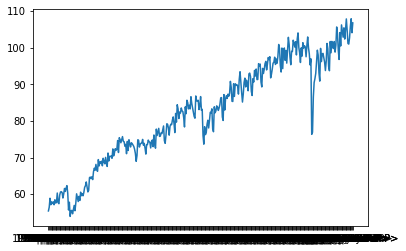

In [386]:
df = pd.read_csv('D:/Dev/Datasets/igae.csv').iloc[0, 1:].reset_index()
df.columns = ['Date', 'Value']
df = df.dropna().reset_index(drop=True)
df = df[~df['Date'].str.contains('Anual')].reset_index()
plt.plot(df['Date'], df['Value'])
logValues = np.log(df['Value'].astype(float))
dataTensor = torch.tensor(logValues.to_numpy(), dtype=torch.float32)

In [526]:
class StockDataset(Dataset):
    def __init__(self, data, seqLen):
        self.data = data
        self.seqLen = seqLen

    def __len__(self):
        return len(self.data) - self.seqLen
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seqLen]
        y = self.data[idx+self.seqLen]
        return x, y

trainSize = int(0.8 * len(dataTensor))
trainData = dataTensor[:trainSize]
valData = dataTensor[trainSize:]

seqLen=13
batchSize=64

trainDataset = StockDataset(trainData, seqLen)
valDataset = StockDataset(trainData, seqLen)


trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=False)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)


In [527]:
trainLosses = []
valLosses = []
valAccs = []

In [528]:
# lossFunc = nn.BCEWithLogitsLoss()
lossFunc = nn.MSELoss()
optimizer = Adam(model.parameters())

def getBatchAcc(preds, targets):
    targetMean = torch.mean(targets)
    ssTotal = torch.sum((targets - targetMean)**2)
    ssResid = torch.sum((targets - preds)**2)
    return 1 - (ssResid / ssTotal)

def validate():
    model.eval() 
    valLoss = 0
    valAcc = 0

    with torch.no_grad():
        for x, y in valLoader:
            x, y = x.to(device), y.to(device)

            batchSize = x.size(0)
            memory = model.initStates(batchSize)
            memory = tuple(state.to(device) for state in memory)
            
            for t in range(x.size(1)):
                inValue = x[:, t].unsqueeze(-1) # (batchSize, 1)
                memory = model(inValue, memory)

            output = model.predict(memory[0])
            loss = lossFunc(output, y.unsqueeze(-1))

            valLoss += loss.item()
            valAcc += getBatchAcc(output, y.unsqueeze(-1)).item() * batchSize

        valLoss /= len(valLoader.dataset)
        valAcc /= len(valLoader.dataset)

        valLosses.append(valLoss)
        valAccs.append(valAcc)

    return valLoss, valAcc
            
def train():
    model.train()
    trainLoss = 0

    for x, y in trainLoader:
        x, y = x.to(device), y.to(device)
        # x := (batchSize, steps)
        # y := (batchSize)

        batchSize = x.size(0)
        memory = model.initStates(batchSize)
        memory = tuple(state.to(device) for state in memory)

        # Iter through time
        for t in range(x.size(1)):
            inValue = x[:, t].unsqueeze(-1) # (batchSize, 1)
            memory = model(inValue, memory)

        output = model.predict(memory[0])
        loss = lossFunc(output, y.unsqueeze(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()
    
    trainLoss /= len(trainLoader.dataset)
    trainLosses.append(trainLoss)

    return trainLoss


In [ ]:
maxpatience = 200
bestvalloss = float('inf')
bestWeights = None
patience = 0

for epoch in range(20000):
    tLoss = train()
    vLoss, vAcc = validate()

    if vLoss < bestvalloss:
        bestvalloss = vLoss
        patience = 0

        bestWeights = copy.deepcopy(model.state_dict())
    else:
        patience += 1

    if patience >= maxpatience:
        print(f'Lost patience at epoch {epoch}')
        print(f'(train) Loss: {tLoss:.4f}')
        print(f'(val) Loss: {vLoss:.4f} R2: {vAcc:.4f}')
        break

    if(epoch % 200 == 0):
        print(f'Epoch {epoch}')
        print(f'(train) Loss: {tLoss:.4f}')
        print(f'(val) Loss: {vLoss:.4f} R2: {vAcc:.4f}')

Epoch 0
(train) Loss: 0.2729
(val) Loss: 0.2639 R2: -12113.0718
Epoch 200
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.0588
Epoch 400
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4081
Epoch 600
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4138
Epoch 800
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4224
Epoch 1000
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4337
Epoch 1200
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4458
Epoch 1400
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4575
Epoch 1600
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4738
Epoch 1800
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4872
Epoch 2000
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4949
Epoch 2200
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.5022
Epoch 2400
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: -0.0724
Epoch 2600
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.5095
Epoch 2800
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.5129
Epoch 3000
(train) Loss: 0.0000
(val) Loss: 0.0000 R2: 0.4560
Epoch 320

In [530]:
model.load_state_dict(bestWeights)

<All keys matched successfully>

In [547]:
torch.save(bestWeights, 'bestLSTM.pt')

In [619]:
targets = torch.tensor([])
preds = torch.tensor([])

for x, y in valLoader:
    with torch.no_grad():
        for x, y in valLoader:
            x, y = x.to(device), y.to(device)

            batchSize = x.size(0)
            memory = model.initStates(batchSize)
            memory = tuple(state.to(device) for state in memory)
            
            for t in range(x.size(1)):
                inValue = x[:, t].unsqueeze(-1) # (batchSize, 1)
                memory = model(inValue, memory)
                
            output = model.predict(memory[0]).to('cpu')

            preds = torch.cat((preds, output.squeeze(-1)), dim=-1)
            targets = torch.cat((targets, y.to('cpu')), dim=-1)


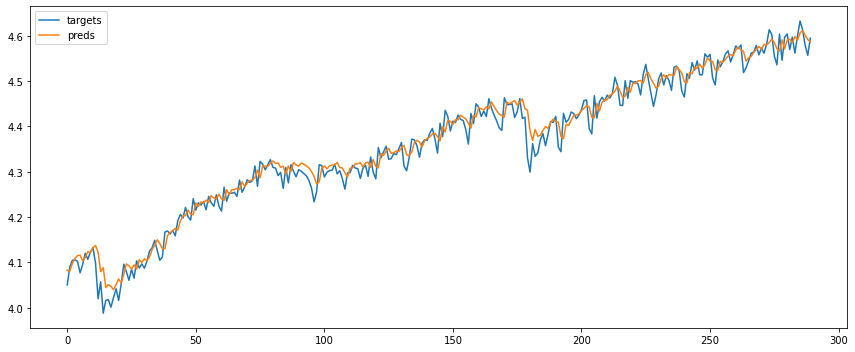

In [620]:
to=len(trainLoader.dataset)
plt.figure(figsize=(12, 5))
plt.plot(targets[0:to], label='targets')
plt.plot(preds[0:to], label='preds')
plt.legend()
plt.tight_layout()
plt.show()


In [645]:
df.iloc[-13:]['Date']

366         2023|Julio<P>
367        2023|Agosto<P>
368    2023|Septiembre<P>
369       2023|Octubre<P>
370     2023|Noviembre<P>
371     2023|Diciembre<P>
372         2024|Enero<P>
373       2024|Febrero<P>
374         2024|Marzo<P>
375         2024|Abril<P>
376          2024|Mayo<P>
377         2024|Junio<R>
378         2024|Julio<P>
Name: Date, dtype: object

In [710]:
rolling = dataTensor[-13:]

In [715]:
future = torch.zeros((13), dtype=torch.float32)
future = future.to(device)

comparizon = torch.zeros_like(dataTensor)
comparizon = comparizon.to(device)

with torch.no_grad():
    memory = model.initStates(1)
    rolling = rolling.to(device)
    memory = tuple(state.squeeze().to(device) for state in memory)
    
    for x in rolling:
        memory = model(x.unsqueeze(-1), memory)
        # comparizon[idx] = model.predict(memory[0])
    
    future[0] = model.predict(memory[0])

    for idx in range(1, len(future)):
        memory = model(future[idx-1].unsqueeze(-1), memory)
        future[idx] = model.predict(memory[0])

future = future.to('cpu')
comparizon = comparizon.to('cpu')

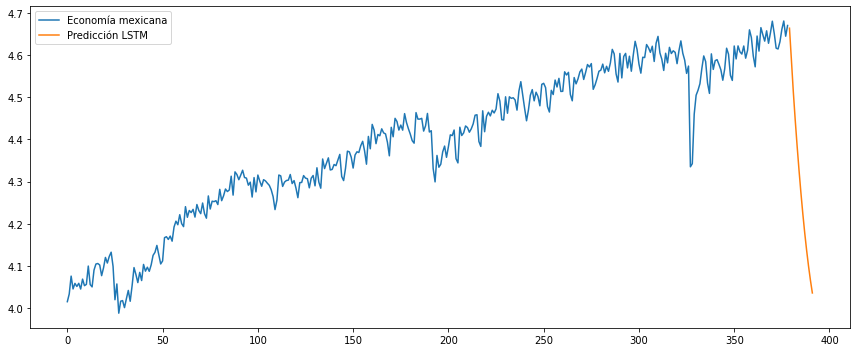

In [718]:
plt.figure(figsize=(12, 5))
plt.plot(dataTensor, label='Economía mexicana')
# plt.plot(comparizon, label='Comp')
plt.plot(torch.arange(len(dataTensor), len(dataTensor)+len(future)), future, label='Predicción LSTM')
plt.legend()
plt.tight_layout()
plt.show()

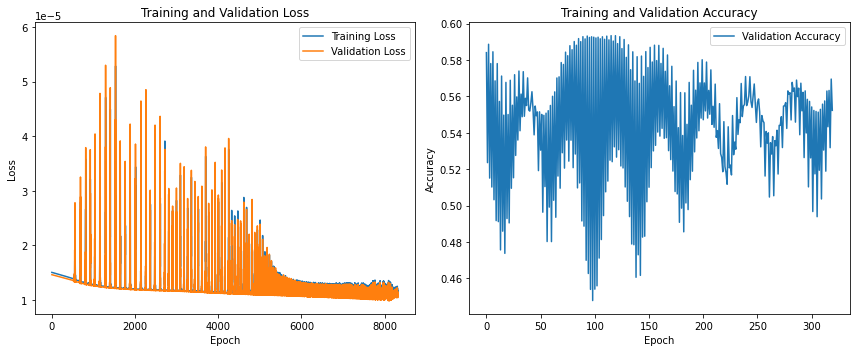

In [548]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainLosses[1000:], label='Training Loss')
plt.plot(valLosses[1000:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs[9000:], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()